# Car Parking Area Detection

## Information
- dataset : https://www.kaggle.com/daggysheep/find-a-car-park
- reference source : https://www.kaggle.com/jonghyunlee1993/kaggle-park-lot-full-free-class-activation-mapping
- blog : https://yscho03.tistory.com/85

## Setup

In [1]:
import os
import glob
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import *

In [2]:
'>>> Tensorflow Version: {}'.format(tf.__version__)

'>>> Tensorflow Version: 2.3.0'

In [4]:
gpus = tf.config.experimental.list_logical_devices('GPU')
gpus

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

## Load Dataset

In [5]:
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, 'datasets')
MODEL_DIR = os.path.join('models')
MODEL_FILE_PATH = os.path.join(MODEL_DIR, 'car_parking_area_detection_model.h5')

In [6]:
data_path = os.path.join(DATASET_DIR, 'data')
full_images = glob.glob(os.path.join(data_path, 'Full/*.jpg'))
free_images = glob.glob(os.path.join(data_path, 'Free/*.jpg'))

## Visualize the data

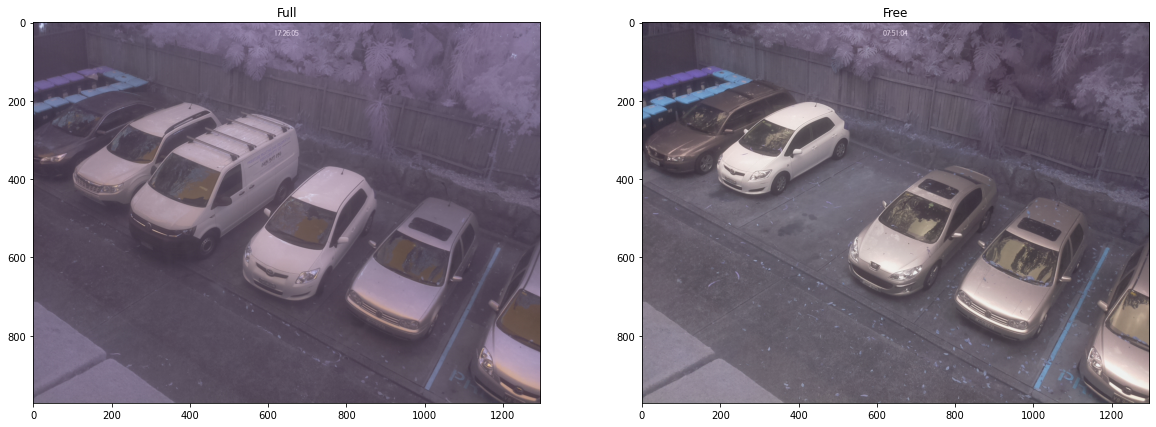

In [7]:
plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
plt.title("Full")
plt.imshow(cv2.imread(full_images[0]))

plt.subplot(1,2,2)
plt.title("Free")
plt.imshow(cv2.imread(free_images[0]))

plt.show()

## Create Dataset objects

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    brightness_range = [0.8, 1.2],
    shear_range = 0.01,
    zoom_range = [0.9, 1.1],
    validation_split = 0.1,
    preprocessing_function = preprocess_input
)
 
val_datagen = ImageDataGenerator(
    validation_split = 0.1,
    preprocessing_function = preprocess_input
)

In [9]:
train_gen = train_datagen.flow_from_directory(
    data_path,
    target_size = (224, 224),
    classes = ['Full', 'Free'],
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    subset = 'training'
)
 
val_gen = val_datagen.flow_from_directory(
    data_path,
    target_size = (224, 224),
    classes = ['Full', 'Free'],
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False,
    subset = 'validation'
)

Found 2937 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


In [10]:
print(val_gen.class_indices)

{'Full': 0, 'Free': 1}


## Build Model

In [11]:
def build_model():
    base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model = build_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [13]:
for layer in model.layers:
    layer.trainable = True

## Training

In [14]:
history = model.fit_generator(
    train_gen,
    validation_data = val_gen,
    epochs = 20,
    steps_per_epoch = len(train_gen) // 32,
    validation_steps = len(val_gen) // 32,
    callbacks = [
        ModelCheckpoint(MODEL_FILE_PATH, monitor = 'val_acc', save_best_only = True, verbose = 1)
    ]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
2/2 [==============================] - 1s 521ms/step - loss: 0.7043 - accuracy: 0.6406
Epoch 2/20
2/2 [==============================] - 1s 728ms/step - loss: 0.5163 - accuracy: 0.7188
Epoch 3/20
2/2 [==============================] - 1s 672ms/step - loss: 0.6755 - accuracy: 0.8438
Epoch 4/20
2/2 [==============================] - 1s 678ms/step - loss: 0.3244 - accuracy: 0.9219
Epoch 5/20
2/2 [==============================] - 1s 445ms/step - loss: 0.4095 - accuracy: 0.8438
Epoch 6/20
2/2 [==============================] - 1s 436ms/step - loss: 0.2070 - accuracy: 0.8906
Epoch 7/20
2/2 [==============================] - 1s 453ms/step - loss: 0.1350 - accuracy: 0.9531
Epoch 8/20
2/2 [==============================] - 1s 457ms/step - loss: 0.3003 - accuracy: 0.9062
Epoch 9/20
2/2 [==============================] - 1s 465ms/step - loss: 0.1335 - accuracy: 0.9688
Epoch 10/20
2/2 [=========================

In [15]:
model.save(MODEL_FILE_PATH)

## Inference

In [16]:
model = load_model(MODEL_FILE_PATH)

In [17]:
last_weight = model.layers[-1].get_weights()[0]
new_model = Model(
    inputs = model.input,
    outputs = (
        model.layers[-3].output, 
        model.layers[-1].output
    )
)
 
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

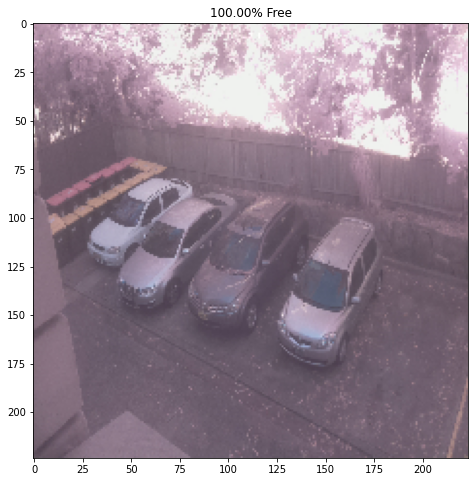

In [18]:
test_img = img_to_array(load_img(os.path.join(data_path, 'Free/img_129173058.jpg'), target_size=(224, 224)))
test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
pred = model.predict(test_input)
 
plt.figure(figsize=(8, 8))
plt.title('%.2f%% Free' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

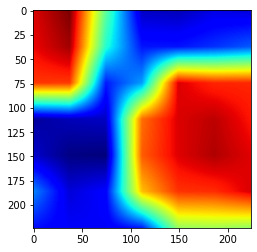

In [19]:
last_conv_output, pred = new_model.predict(test_input)
 
last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280)
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) => (224, 224, 1280)
 
pred_class = np.argmax(pred) # 0: Full, 1: Free
predicted_class_weights = last_weight[:, pred_class] # (1280, 1)
 
final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224)) # (224*224, 1280) dot_produt (1280, 1) = (224*224, 1)
 
plt.imshow(final_output, cmap='jet')

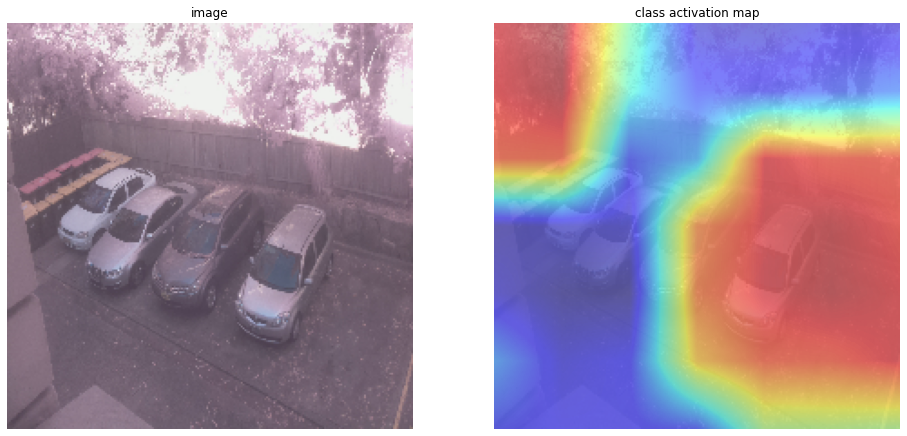

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)
 
ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')
 
ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()